In [1]:
import os
import numpy as np
import galsim
import sys
import descwl
import argparse

import copy
%matplotlib inline
import matplotlib.pyplot as plt

#importing scarlet to make RGB images
import scarlet.display

sys.path.insert(0,os.path.dirname(os.getcwd()))
import btk
from btk import config

In [2]:
#Input catalog name
catalog_name = os.path.join(os.path.dirname(os.getcwd()), 'OneDegSq.fits')

In [3]:
def plot_blends(param, blend_images, blend_list, stack_centers=None, limits=None):
    """Plots blend images as RGB(g,r,i) image, sum in all bands, and RGB with centers of objects marked"""
    if stack_centers is None:
        stack_centers = [[]]*param.batch_size
    for i in range(param.batch_size):    
        num = len(blend_list[i])
        images = np.transpose(blend_images[i, :, :, 1:4], axes=(2,0,1))
        norm = scarlet.display.Asinh(img=images, Q=20)
        blend_img_rgb = scarlet.display.img_to_rgb(images, norm=norm)
        plt.figure(figsize=(8,3))
        plt.subplot(131)
        plt.imshow(blend_img_rgb)
        if limits:
            plt.xlim(limits)
            plt.ylim(limits)
        plt.title("gri bands")
        plt.axis('off')
        plt.subplot(132)
        plt.imshow(np.sum(blend_images[i, :, :, :], axis=2))
        plt.title("Sum")
        if limits:
            plt.xlim(limits)
            plt.ylim(limits)
        plt.axis('off')

        plt.subplot(133)
        plt.imshow(blend_img_rgb)
        plt.title("%i objects with centers"%num)
        for entry in blend_list[i]:
            #plt.plot(entry['ra']/0.2 + 59.5, entry['dec']/0.2 + 59.5,'rx')
            plt.plot(entry['dx'], entry['dy'],'rx')
        if limits:
            plt.xlim(limits)
            plt.ylim(limits)
        for cent in stack_centers[i]:
            plt.plot(cent[0], cent[1],'go', fillstyle='none')
        plt.axis('off')
        plt.show()

def plot_with_isolated(param, blend_images, isolated_images,
                       blend_list, limits=None):
    """Plots blend images and isolated images of all objects in the blend as RGB(g,r,i) images"""
    for i in range(param.batch_size):    
        num = param.max_number
        images = np.transpose(blend_images[i, :, :, 1:4], axes=(2,0,1))
        norm = scarlet.display.Asinh(img=images, Q=20)
        blend_img_rgb = scarlet.display.img_to_rgb(images, norm=norm)
        plt.figure(figsize=(2,2))
        plt.imshow(blend_img_rgb)
        plt.title("%i objects"%len(blend_list[i]))
        if limits:
            plt.xlim(limits)
            plt.ylim(limits)
        plt.axis('off')
        plt.show()
        plt.figure(figsize=(8,3))
        for j in range(len(blend_list[i])):
            plt.subplot(1, num, j +1 )
            iso_blend = isolated_images[i]
            images = np.transpose(iso_blend[j, :, :, 1:4], axes=(2,0,1))
            blend_img_rgb = scarlet.display.img_to_rgb(images, norm=norm)
            plt.imshow(blend_img_rgb)
            #plt.plot(blend_list[i]['ra'][j]/0.2 + 59, blend_list[i]['dec'][j]/0.2 + 59,'rx')
            if limits:
                plt.xlim(limits)
                plt.ylim(limits)
            plt.axis('off')
        plt.show()

## Running btk to output blend images with noise

In [4]:
# Load parameters
param = config.Simulation_params(catalog_name, max_number=6, batch_size=4)
np.random.seed(param.seed)

#Load input catalog
catalog = btk.get_input_catalog.load_catlog(catalog_name)

#Generate catlogs of blended objects 
blend_generator = btk.create_blend_generator.generate(param, catalog)

#Generates observing conditions for the selected survey_name and all input bands
observing_generator = btk.create_observing_generator.generate(param)

#Generate images of blends in all the observing bands
draw_blend_generator = btk.draw_blends.generate(param, blend_generator, observing_generator) 


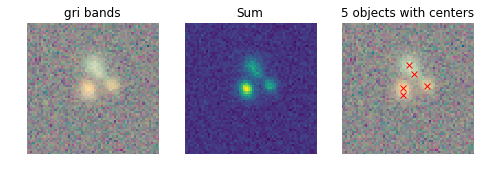

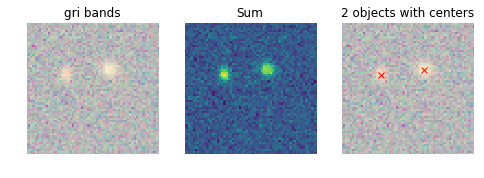

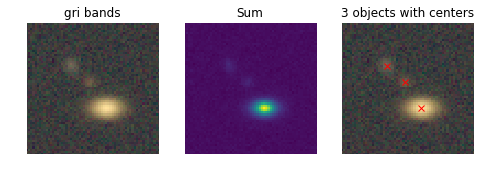

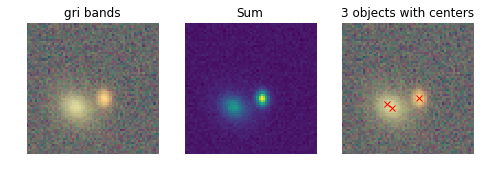

In [5]:
# This cell generates new batch_size number of blends each time it's executed

# Draw blend
blend_results = next(draw_blend_generator)
output = blend_results
blend_images = output['blend_images']
isolated_images = output['isolated_images']
blend_list = output['blend_list']
# Plot blended images
plot_blends(param, blend_images, blend_list, limits=(30,90))

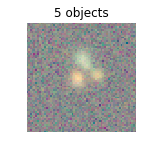

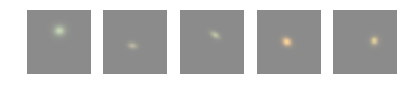

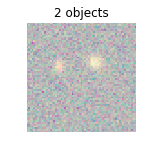

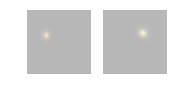

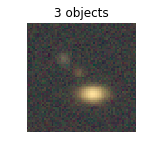

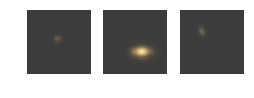

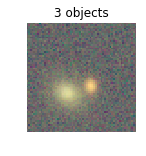

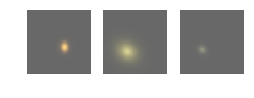

In [6]:
# Plot blended images and the individual objects
plot_with_isolated(param, blend_images, isolated_images,blend_list, limits=(30,90))


## Perform measurement with stack

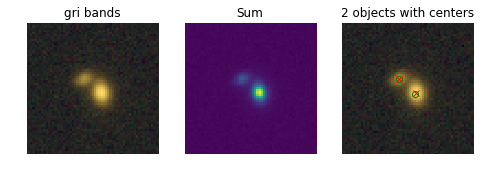

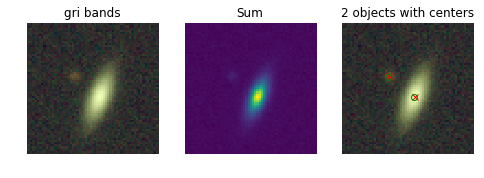

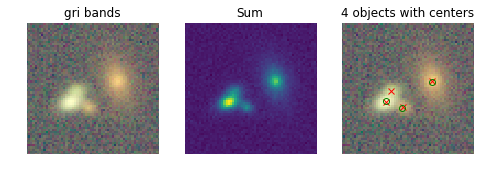

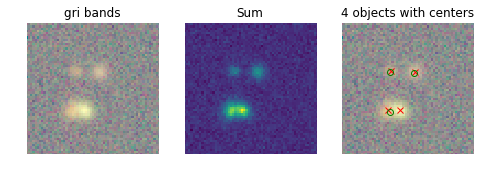

In [7]:

meas_params = btk.utils.Stack_params()
meas_generator = btk.measure.generate(meas_params, draw_blend_generator)
output, _, cat=next(meas_generator)

blend_images = output['blend_images']
isolated_images = output['isolated_images']
blend_list = output['blend_list']
centers = [np.array([cat[i]['base_NaiveCentroid_x'], cat[i]['base_NaiveCentroid_y']]).T for i in range(len(cat))]
plot_blends(param, blend_images, blend_list, centers,limits=(30,90))

## Deblend with scarlet

In [8]:
m_params = btk.utils.Scarlet_params()
m_gen = btk.measure.generate(m_params, draw_blend_generator)
output, deblend_images,_ = next(m_gen)

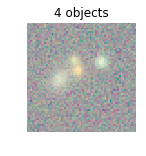

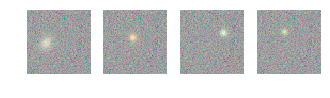

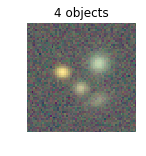

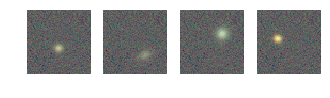

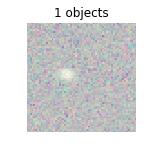

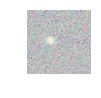

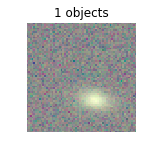

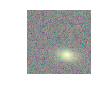

In [9]:
blend_images = output['blend_images']
isolated_images = output['isolated_images']
blend_list = output['blend_list']
plot_with_isolated(param, blend_images, deblend_images,blend_list, limits=(30,90))

## Running btk to output noiseless blend images

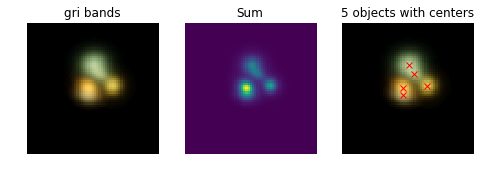

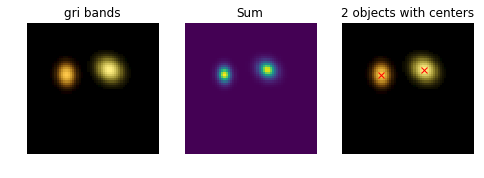

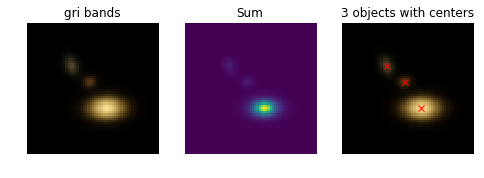

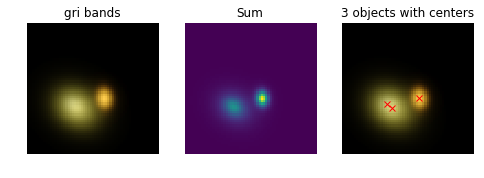

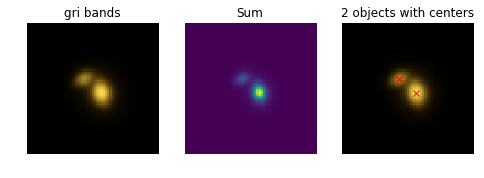

In [10]:
# Repeat with no noise in blended images
param = config.Simulation_params(catalog_name, max_number=6, batch_size=5, add_noise=False)
np.random.seed(param.seed)
catalog = btk.get_input_catalog.load_catlog(catalog_name)
blend_genrator = btk.create_blend_generator.generate(param, catalog)
observing_genrator = btk.create_observing_generator.generate(param)
draw_blend_generator = btk.draw_blends.generate(param, blend_genrator, observing_genrator)  

blend_results = next(draw_blend_generator)
output = blend_results
blend_images = output['blend_images']
isolated_images = output['isolated_images']
blend_list = output['blend_list']
plot_blends(param, blend_images, blend_list, limits=(30,90))

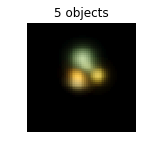

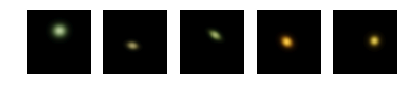

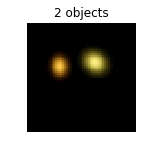

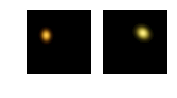

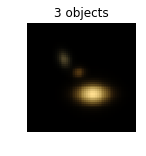

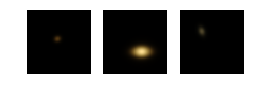

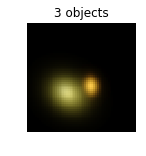

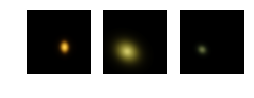

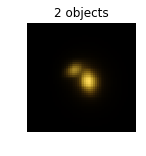

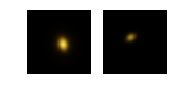

In [11]:
plot_with_isolated(param, blend_images, isolated_images,blend_list, limits=(30,90))